# Univ DS-1 Project 
By :
- ## Dewang Vinchhi
- ## Ashwin 

# Installation of Required Libraries

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
# # Updating the application repository and installing chrome driver
# !apt update 
# !apt install chromium-chromedriver 
# !pip install -q selenium webdriver_manager 

# Importing Required Libraries

In [25]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys 
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.firefox.options import Options

# from selenium.webdriver.firefox.service import Service as FirefoxService
# from webdriver_manager.firefox import GeckoDriverManager

import re 
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import sqlite3
from sqlite3 import OperationalError
import os

# Writing Helpful classes and functions for scraping data
## Class to interact with database
This class has following functions
- make_query() -> It allows to make query from database
- On instantiating this class it will either create connection to existing database or will ask to create new
- make_changes() -> you can make new tables or delete records using this from database. This does not accepts any arguments
- execute_many() -> Primary purpose is to be able to add many records (rows) in possibly one line
- get_cols() -> returns the name of columns of the table name passed
- quit_db() -> Disconnects with the database

In [26]:
class DatabaseScrape:
    

    def __init__(self, dbName, dbPath='.',):

        self.dbName = dbName
        self.dbPath = dbPath
        
        if os.path.exists(self.dbPath):
            # current_folder = os.getcwd()
            if self.dbName in os.listdir(self.dbPath):
                self.conn = sqlite3.connect(os.path.join(self.dbPath, self.dbName))
                self.cur = self.conn.cursor()
                print("Database connection successfull")
            else:
                print("There is no such database at given path, creating new database")
                print("Press Enter to create new database or")
                input("Press ctrl+c to exit")
                
                self.conn = sqlite3.connect(os.path.join(self.dbPath, self.dbName))
                self.cur = self.conn.cursor()
                print("Database Created Successfully")
        else:
            print("The path do not exists, check the path")
            return

    def make_changes(self, query):
        self.cur.execute(query)
        self.conn.commit()

    def make_query(self, query):
        self.cur.execute(query)
        try:
            return self.cur.fetchall()
        except:
            print("There was some error, check query!")
    
    def get_cols(self, table_name):
        r = self.cur.execute(f"PRAGMA TABLE_INFO({table_name})")
        r = [c[1] for c in r]
        return r

    def execute_many(self, query, data_list):
        self.cur.executemany(query, data_list)
        self.conn.commit()

    def quit_db(self):
        self.conn.close()
        print("Database connection closed")

## HotelWebsite Class
This is a class. It will store website details from which we want to get hotel information

In [27]:
class HotelWebsite:
    '''
    A class object that will store the information of websites 
    that we will be scraping

    '''    
    def __init__(self, url, xpathSearch, searchButton):
        self.url = url
        self.xpathSearch = xpathSearch
        
        self.searchButton = searchButton

## Functions to:
- Start a driver
- Open a website and make a search.

In [28]:
def start_driver():
    options = Options()
    # options.add_argument("--headless")
    # options.add_argument('--no-sandbox')
    # options.add_argument('--disable-dev-shm-usage')
    # options.add_argument('--lang=en_US') 
    # service = FirefoxService(executable_path=GeckoDriverManager().install())
    driver = webdriver.Firefox(options=options)
    driver.maximize_window()
    print("Driver opened")
    return driver

def search(web_site, driver, cityName):
    # Load the main URL
    driver.get(web_site.url)
    
    # wait for page to load
    driver.implicitly_wait(3)

    # finding input element
    search_box = driver.find_element(
        By.XPATH, web_site.xpathSearch)
    
    # finding search button element
    butt = driver.find_element(
        By.XPATH, web_site.searchButton)

    # entering the search query aka cityName
    search_box.send_keys(cityName)
    time.sleep(7)
    
    butt.click()
    time.sleep(2)
    print(f"Search {cityName} Finished")
    print('--'*50)
    return driver

## A function that scrapes the webpage containing hotel details -> hotel profile scraper

In [29]:
# HOTEL PROFILE CRAWLER
# runs inside scrape_hotel_and_link
# gathers the data of current profile opened
def hotel_profile_crawler(driver, link, hName):
    driver = driver
    

    # Open a new window
    driver.execute_script("window.open('');")

    # Switch to the new window and open new URL
    driver.switch_to.window(driver.window_handles[1])
    
    # waits for the net duration and in this duration all the operations by selenium should
    # finish or it will return empty strings or dictionary or lists
    driver.implicitly_wait(10)
    driver.get(link)
    
    # ADDRESS - ok
    address = driver.find_element(By.CSS_SELECTOR, ".hp_address_subtitle").text.strip()
    # print('ADDRESS')
    # print(address, end='\n\n')
    
    # REVIEWS - ok
    try:
        review_count = driver.find_element(By.XPATH, "//span[@class=\"b5cd09854e c90c0a70d3 db63693c62\"]").text.strip()
        review_count = re.findall("\d+" , review_count)
        review_count = ''.join(review_count)
    except NoSuchElementException:
        review_count = ''
    try:
        avg_rvw = driver.find_element(By.XPATH, "//div[@class=\"b5cd09854e d10a6220b4\"]").text.strip()
    except NoSuchElementException:
        avg_rvw = ''
    
    # print("REVIEW")
    # print(review_count, avg_rvw, end="\n\n")
    
    # FACILITIES - ok
    facility_box = driver.find_element(By.XPATH, "//div[@class=\"hotel-facilities__list\"]")
    
    facilities = {}
    for item in facility_box.find_elements(By.XPATH, "//div[@class=\"hotel-facilities-group\"]"):
        title = item.find_element(By.TAG_NAME, 'div').text.strip()
        try:
            facility_names = item.find_elements(By.TAG_NAME, 'li')
            facility_names = [n.text.strip() for n in facility_names]
        except NoSuchElementException:
            facility_names = ''
        try:
            description = item.find_element(By.XPATH, '//*[@class="bui-spacer--medium hotel-facilities-group__policy"]').text.strip()
        except NoSuchElementException:
            description = ''
        facilities[title] = facility_names + [description]
        
    # HOTEL SURROUNDINGS - ok
    # List of block that contain distances to nearest places
    
    # scroll upto certain element to let the website load the data that next we want to obtain
    try:
        driver.implicitly_wait(2)
        element = driver.find_element(By.XPATH, '//div[@class="hp_location_block__section_container"]')
    except NoSuchElementException as E:
        driver.implicitly_wait(2)
        element = driver.find_element(By.XPATH, '//div[@class="d31796cb42"]')
    
    driver.execute_script("arguments[0].scrollIntoView(true);", element)
    
    # Finding the element that has data regarding nearby places to visit
    container_blocks = driver.find_elements(By.XPATH, '//div[@class="hp_location_block__section_container"]')
    
    if container_blocks =={}:
        container_blocks = driver.find_elements(By.XPATH, '//div[@class="d31796cb42"]')

    # Titles of block regarding the nearby places
    block_titles = driver.find_elements(By.XPATH, '''//span[@class="bui-title__text"]''')

    if block_titles == {}:
        block_titles = driver.find_elements(By.XPATH, '''//div[@class="ac78a73c96 f0d4d6a2f5 fda3b74d0d"]''')

    # iterating over the names of block titles to save them as the dictionary keys
    block_titles = [N.text.strip() for N in block_titles]
    iter_block_titles = iter(block_titles)


    # empty dictionary to store information from each block
    hotel_surrounding = dict()

    # iterating through the blocks elemets to extract information
    for block in container_blocks[:-1]:

        # information is in list tag 
        driver.implicitly_wait(1.5)
        list_elements = block.find_elements(By.TAG_NAME, "li")

        # empty list to store place name and distance to it
        place_n_dist_list = list()

        # iterating through list elemets
        for ele in list_elements:
            driver.implicitly_wait(0.5)
            
            # every list element has 3 div tags and info is stored in 2nd and 3rd
            place = ele.find_elements(By.TAG_NAME, "div")
            assert place != []
            
            
            # appending in previously created list
            spam1, spam2 = (place[1].text.strip(), place[2].text)
            place_n_dist_list.append((spam1, spam2))

        # title of current block
        # key = block title
        # value = place and distance list created previously
        hotel_surrounding[next(iter_block_titles)] = place_n_dist_list
        assert hotel_surrounding != {}
    
    # ADD DATA TO DATABASE
    # COLUMNS = h_id, link, h_name, avg_rvw, rvw_count, facilites, hotel_surroundings, address
    
    tupled_list = [link,
                  hName,
                  address,
                  avg_rvw,
                  review_count,
                  str(facilities),
                  str(hotel_surrounding)]
    
    # Closing new_url tab
    driver.close()

    # Switching to old tab
    driver.switch_to.window(driver.window_handles[0])
    
    return tupled_list

## Scrape hotel and link
We are not directly opening the hotel profiles to scrape the hotel information. We first save the links to all hotels for a city that a search shows and then later open the hotel links directly and scrape information.
- This function recieves driver that has search result opened and it will simply find the name and links of hotels
- This function is finds hotel names and links for 1 city.
- Find total number of properties (hotels)
- Find the name and links using selenium.
- store it in a list
- Goto next page of search results
- repeat of getting name and links of hotel
- Append in a list.
- return the list

In [30]:
def scrape_hotel_and_link(web_site, city_id, driver, database):
    
    time.sleep(3)

    num_of_properties = driver.find_element(
        By.XPATH,
        "//h1[@class='e1f827110f d3a14d00da']").text.strip()
    num_of_properties = re.findall("\d+", num_of_properties)
    num_of_properties = int(''.join(num_of_properties)) 
    print(f"Number of properties = {num_of_properties}")
    print("---" * 50)
    
    if num_of_properties < 400:
        numPages = (int(num_of_properties) // 25) +1
    else:
        # first is already extracted
        numPages = 20
    
    for pageN in range(numPages):
        # per page there are 25 results (or cards)
        links_ = driver.find_elements(By.XPATH, "//h3[@class=\"a4225678b2\"]/a")
        driver.implicitly_wait(5)
        links_ = [n.get_attribute("href") for n in links_]

        titles = driver.find_elements(By.XPATH, "//h3[@class=\"a4225678b2\"]/a/div[1]")
        driver.implicitly_wait(5)
        titles = [n.text.strip() for n in titles]

        # ===========================================================================
        for l, hName in zip(links_, titles):
            data_list = hotel_profile_crawler(driver=driver,link = l, hName= hName)
            
            full_data = [city_id] + data_list
            full_data = [tuple(full_data)]
            database.execute_many('''
                INSERT INTO hotel_data(
                    c_id,
                    link,
                    h_name,
                    address,
                    avg_rvw,
                    rvw_count,
                    facilites,
                    hotel_surroundings
                ) 
                VALUES(?,?,?,?,?,?,?,?)''', full_data
            )

        # ===========================================================================
        next_page_butt = driver.find_element(
            By.XPATH, 
            "//*[@id='search_results_table']/div[2]/div/div/div/div[4]/div[2]/nav/div/div[3]/button") \
            .click()
        
        time.sleep(3)
        


## crawler function
- This is the main runner, this function will call other functions.

Following are the steps:
- Start the driver
- It receives list of cities to scrape as a argument.
- LOOP through cities to scrape hotel data
    - store the city name in data base and assign it a ID.
    - Run the search function
    - Run the scrape_hotel_and_links function
    - Store the list which has name and links of hotel in database. Assign the hotel a ID
- Quit the database and driver
- END

In [31]:
def crawler(web_site, cityNameList, db_):
    """
    This is specific to booking.com website
    """
    # connect to firefox driver
    driver = start_driver()
    
    cityNameList = [(i+1, city) for i, city in enumerate(cityNameList)]
    
    db_.execute_many("INSERT INTO cities(city_id, city_name) VALUES(?, ?)", cityNameList)

    for city_id, cityName in cityNameList:
        # search using the city name in search bar
        # sequence of actions to take to successfully make search

        # inputing the search query (query is cityName) and fetching website into driver1
        driver1 = search(web_site, driver, cityName)

        # saving the hotel names and link as a list of tuples
        scrape_hotel_and_link(web_site, 
                           city_id= city_id, 
                           driver=driver1, 
                           database = db_)
  
    # quit driver after use
    db_.quit_db()
    driver1.quit()

# Create database and tables

In [32]:
hotels = DatabaseScrape("hotels_database.db")

# creating tables
hotels.make_changes(
    """CREATE TABLE cities(
        city_id INTEGER PRIMARY KEY,
        city_name VARCHAR
        )"""
)

# COLUMNS = h_id, c_id link, h_name, avg_rvw, rvw_count, facilites, hotel_surroundings, address
hotels.make_changes(
    '''CREATE TABLE hotel_data(
        h_id INTEGER PRIMARY KEY AUTOINCREMENT,
        c_id INTEGER,
        link VARCHAR,
        h_name VARCHAR,
        address VARCHAR,
        avg_rvw VARCHAR,
        rvw_count VARCHAR,
        facilites VARCHAR,
        hotel_surroundings VARCHAR,
        FOREIGN KEY (c_id) REFERENCES cities(city_id)
    )'''
)

There is no such database at given path, creating new database
Press Enter to create new database or


Press ctrl+c to exit 


Database Created Successfully


# Scraper - runs all the code

In [33]:
cities = ['Delhi','Mumbai','Varanasi','Jaipur','Agra']

bookingsCom = HotelWebsite(
    url = "https://www.booking.com",
    xpathSearch = '//input[@name="ss"]',
    searchButton = "//button[@type=\"submit\"]",
)


crawler(bookingsCom, cities, hotels)

Driver opened
Search Delhi Finished
----------------------------------------------------------------------------------------------------
Number of properties = 1345
------------------------------------------------------------------------------------------------------------------------------------------------------
Search Mumbai Finished
----------------------------------------------------------------------------------------------------
Number of properties = 620
------------------------------------------------------------------------------------------------------------------------------------------------------
Search Varanasi Finished
----------------------------------------------------------------------------------------------------
Number of properties = 178
------------------------------------------------------------------------------------------------------------------------------------------------------
Search Jaipur Finished
-------------------------------------------------------

# EXPLORATORY DATA ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Class to interact with database

### Getting data from the database - optional

In [3]:
database = DatabaseScrape("hotels_database.db")

data = database.make_query("SELECT * FROM hotel_data")
columns = database.get_cols("hotel_data")

dataframe = pd.DataFrame(data, columns = columns)

display(dataframe.head())

Database connection successfull


,h_id,c_id,link,h_name,address,avg_rvw,rvw_count,facilites,hotel_surroundings
0,1,1,https://www.booking.com/hotel/in/arch-plaza-ne...,Hotel Arch Plaza - Near Delhi Airport,Bijwasan Road Near Indira Gandhi International...,5.5,2,"{'Outdoors': ['Picnic area', 'Outdoor furnitur...","{""What's nearby"": [('Candor Badminton Court An..."
1,2,1,https://www.booking.com/hotel/in/discovery-new...,Hotel D'Capitol - Delhi Airport,"786, Mahipalpur Small Signal,Vasant Kunj Road ...",7.9,3883,"{'Outdoors': ['Terrace', 'Garden', 'WiFi is av...","{""What's nearby"": [('Herbal Garden', '5 km'), ..."
2,3,1,https://www.booking.com/hotel/in/srivinayak.ht...,Hotel Shri Vinayak at New Delhi Railway Statio...,"7418, Arakashan Road, Saran building, Street N...",8.2,169,"{'Outdoors': ['Outdoor fireplace', 'Outdoor fu...","{""What's nearby"": [('Central Park', '1.4 km'),..."
3,4,1,https://www.booking.com/hotel/in/venus-interna...,Hotel Smart Plaza Delhi Airport,"A Block, Near Indira Gandhi International Airp...",8.4,2915,"{'Activities': ['Tennis equipment', 'Evening e...","{""What's nearby"": [('Herbal Garden', '5 km'), ..."
4,5,1,https://www.booking.com/hotel/in/the-ivy-grand...,Hotel The IVY Grand With Free Secured Parking,"Plot No.1, Block 8, D B Gupta Road Paharganj, ...",8.2,470,"{'Food & Drink': ['Breakfast in the room', 'Wi...","{""What's nearby"": [('Tikona Park', '1.4 km'), ..."


## Exploring the data
### Dropping duplicates

In [4]:

duplicate_count = dataframe[dataframe[['h_name', 'address']].duplicated()].count()[0]
print(f"There are {duplicate_count} duplicates in the data.")

print("\nDropping the duplicates")
dataframe[['h_name', 'address']] = dataframe[['h_name', 'address']].drop_duplicates()
print("\nDuplicates Dropped.")

There are 85 duplicates in the data.

Dropping the duplicates

Duplicates Dropped.


In [5]:
# spelling correction
dataframe.rename(columns={"facilites" :"facilities"}, inplace=True)

### Converting the string of 'facilities' and "hotel_surrondings" column to dictionary

In [6]:
dataframe['facilities'] = dataframe['facilities'].apply(eval)
dataframe['hotel_surroundings'] = dataframe['hotel_surroundings'].apply(eval)

In [7]:
# optional
# dataframe.to_pickle("processed_df.pkl")

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2151 entries, 0 to 2150
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   h_id                2151 non-null   int64 
 1   c_id                2151 non-null   int64 
 2   link                2151 non-null   object
 3   h_name              2066 non-null   object
 4   address             2066 non-null   object
 5   avg_rvw             2151 non-null   object
 6   rvw_count           2151 non-null   object
 7   facilities          2151 non-null   object
 8   hotel_surroundings  2151 non-null   object
dtypes: int64(2), object(7)
memory usage: 151.4+ KB


In [9]:
dataframe.dtypes

h_id                   int64
c_id                   int64
link                  object
h_name                object
address               object
avg_rvw               object
rvw_count             object
facilities            object
hotel_surroundings    object
dtype: object

In [10]:
dataframe['link'] = dataframe['link'].astype('string')
dataframe['h_name'] = dataframe['h_name'].astype('string')
dataframe['address'] = dataframe['address'].astype('string')
dataframe['avg_rvw'] = dataframe['avg_rvw'].astype('string')
dataframe['rvw_count'] = dataframe['rvw_count'].astype('string')

### CHANGING THE DICTIONARIES KEYS TO COLUMNS

In [11]:
spam = list()
for val in dataframe['facilities'].values:
    spam.extend(list(val.keys()))
    
set(spam)

{'2 swimming pools',
 '3 swimming pools',
 'Accessibility',
 'Activities',
 'Bathroom',
 'Bedroom',
 'Building Characteristics',
 'Business Facilities',
 'Cleaning Services',
 'Common Areas',
 'Entertainment & Family Services',
 'Food & Drink',
 'Front Desk Services',
 'General',
 'Health & Wellness Facilities',
 'Indoor swimming pool',
 'Internet',
 'Kitchen',
 'Kitchen\nFreedom to eat when you want',
 'Languages Spoken',
 'Living Area',
 'Living Area\nSpace for everyone to be together',
 'Media & Technology',
 'Media & Technology\nFun for everyone under one roof',
 'Miscellaneous',
 'Outdoor & View\nEnjoy the view',
 'Outdoor swimming pool',
 'Outdoors',
 'Outdoors\nSit back and relax',
 'Parking',
 'Pets',
 'Pool and Spa',
 'Pool – indoor (kids)',
 'Room Amenities',
 'Room Amenities\nExtra comfort',
 'Safety & security',
 'Services',
 'Services & Extras',
 'Shops',
 'Ski',
 'Spa',
 'Swimming pool',
 'Transportation',
 'View'}

FACILITIES THAT ARE REPEATED IN SOME WAY OR OTHER
- Swimming pool (this is different from the pool for kids)
    - indoor and outdoor is also a gig
- Living Area
- Spa
- Room Amenities
- Outdoors
- Media & technology
- Kitchen
- Different kind of 'services'

In [12]:
# iterating through values of facilities
from copy import copy

# for i, row_val in dataframe['facilities'].iteritems():
def change_facilities(row_val):
    new_dict = copy(row_val)
    new_fts = ['swimming pool', 'living area', 'services', 'spa','kitchen', 'media & technology','outdoors', 'room amenities']
    for x in new_fts:
        new_dict[x] = []
    
    # iterating through the keys of value dictionary
    for key_of_val in row_val.keys():
        # any swimming pool related value is assigned to single same named key = 'swimming pool'
        if 'swimming pool' in key_of_val.lower():
            new_dict['swimming pool'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'living area' in key_of_val.lower():
            new_dict['living area'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'services' in key_of_val.lower():
            new_dict['services'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'spa' in key_of_val.lower():
            new_dict['spa'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'kitchen' in key_of_val.lower():
            new_dict['kitchen'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'media & technology' in key_of_val.lower():
            new_dict['media & technology'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'outdoors' in key_of_val.lower():
            new_dict['outdoors'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
        elif 'room amenities' in key_of_val.lower():
            new_dict['room amenities'].extend(row_val[key_of_val])
            del new_dict[key_of_val]
    
    for x in new_fts:
        if len(new_dict[x]) == 0:
            del new_dict[x]
            
    return new_dict

# dataframe['new_facilities'] = 
dataframe['new_facilities'] = dataframe['facilities'].apply(change_facilities)

In [13]:
dataframe['new_facilities'].head()

0    {'Food & Drink': ['Kids' meals
Additional char...
1    {'Food & Drink': ['Bar', 'Restaurant', 'WiFi i...
2    {'Food & Drink': ['Fruit
Additional charge', '...
3    {'Activities': ['Tennis equipment', 'Evening e...
4    {'Food & Drink': ['Breakfast in the room', 'Wi...
Name: new_facilities, dtype: object

The **hotel surroundings** is dictionary of places nearby, hotspots, restaurents and many different things.

### Imputing the nan ratings of hotel

In [14]:
dataframe['rvw_count'] = dataframe['rvw_count'].replace('', np.nan).astype(np.float32)
dataframe['avg_rvw'] = dataframe['avg_rvw'].replace('', np.nan).astype(np.float32)

display(dataframe.dtypes)

h_id                    int64
c_id                    int64
link                   string
h_name                 string
address                string
avg_rvw               float32
rvw_count             float32
facilities             object
hotel_surroundings     object
new_facilities         object
dtype: object

In [16]:
# imputing the mean of average ratings by city
# imputing the mean of rating count by city

city_wise_mean_ratings = dataframe.groupby('c_id')[['avg_rvw', 'rvw_count']].mean()
for city_id in dataframe['c_id'].unique():
    mean_for_current_city = city_wise_mean_ratings.loc[city_id]
    dataframe[dataframe['c_id']==city_id]['avg_rvw'].fillna(mean_for_current_city[0], inplace=True)
    dataframe[dataframe['c_id']==city_id]['rvw_count'].fillna(mean_for_current_city[1], inplace=True)

C:\Users\devang\AppData\Local\Temp\ipykernel_1276\2513603582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[dataframe['c_id']==city_id]['avg_rvw'].fillna(mean_for_current_city[0], inplace=True)
C:\Users\devang\AppData\Local\Temp\ipykernel_1276\2513603582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[dataframe['c_id']==city_id]['rvw_count'].fillna(mean_for_current_city[1], inplace=True)


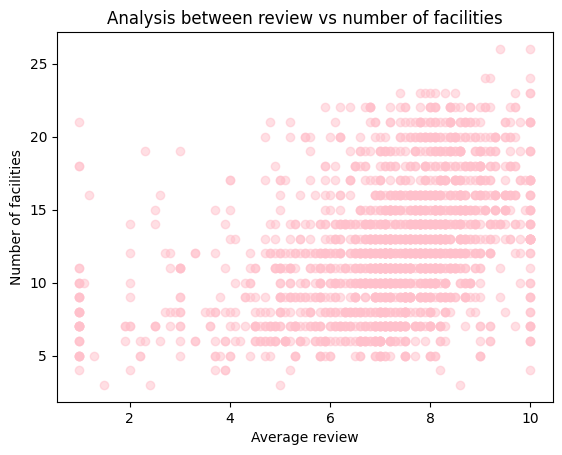

In [17]:
dataframe['number_of_facilities'] =  dataframe.facilities.apply(lambda x: len(x.keys()))

plt.style.use('seaborn-v0_8-pastel')
plt.scatter(dataframe.avg_rvw,dataframe.number_of_facilities, color='pink', alpha=0.5)
plt.xlabel('Average review')
plt.ylabel('Number of facilities')
plt.title('Analysis between review vs number of facilities')
plt.show()

**OBSERVATION**
- There is no obvious relation but,
- Larger number of facilities tend to get higher average reviews

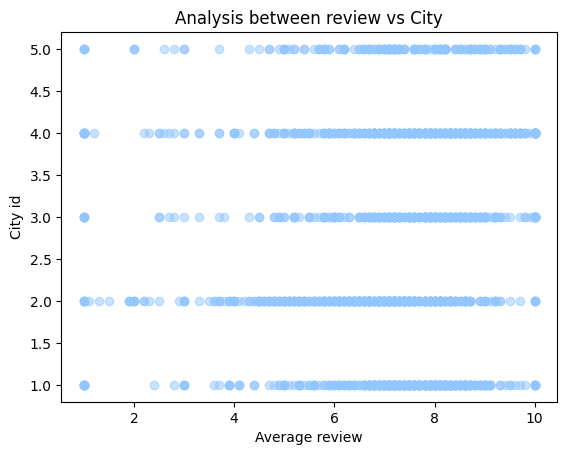

In [18]:
plt.scatter(dataframe.avg_rvw,dataframe.c_id, alpha=0.5)
plt.xlabel('Average review')
plt.ylabel('City id')
plt.title('Analysis between review vs City')
plt.show()

OBSERVATION
- Most ratings are between 5 and 10

In [19]:
dataframe.hotel_surroundings[0]["What's nearby"]

[('Candor Badminton Court And Park', '2.3 km'),
 ('Herbal Garden', '2.5 km'),
 ('Community Park S2302', '3 km'),
 ('Secctor 23 Maarket Park', '3.5 km'),
 ('Tau Devi Lal Park', '3.7 km'),
 ('Cyber Greens Park', '4.3 km'),
 ('Central Park', '4.4 km'),
 ('DLF City Club', '4.6 km'),
 ('RK Convent Park', '4.6 km'),
 ('RWA Park', '4.8 km')]

In [20]:
dataframe.groupby(['number_of_facilities']).mean()[['avg_rvw']]

C:\Users\devang\AppData\Local\Temp\ipykernel_1276\3058326599.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataframe.groupby(['number_of_facilities']).mean()[['avg_rvw']]


,avg_rvw
number_of_facilities,
3,4.375000
4,4.737500
5,5.603921
6,5.964286
7,6.172185
8,6.161000
9,6.776378
10,6.910448
11,6.977586


It is pretty clear that reviews are higher for hotels with more facilities.

So far we have seen that a hotel has many facilities and different restaurents and places around the hotel.

Different hotels have been rated differently and by different number of peoples ( which makes it difficult for use to use this scale directly as in plain english it will be unfair to those hotels which was rated by fewer number of hotels.)

The `facilities` and `hotel surroundngs` columns can be used as in conjunction with `ratings` and `number of people rated`.

The two columns needs to be cleaned and usable to make this idea become fruitful

After getting the data processed and ready to be utilised we can achieve recommendation by doing following:
- Make clusters of similar hotels by using the above mentioned criteria.
- Suggest these clusters from descending order or best to worst.

For now due to lack of time and people we have progressed upto gathering the data and trying to clean the data.